In [0]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import argparse
import os
import torch.nn.functional as F
import torch.optim as optim

In [0]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

In [0]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)
train_set = datasets.MNIST(root=root, train=True, transform=trans, download=True)
test_set = datasets.MNIST(root=root, train=False, transform=trans, download=True)

In [0]:
batch_size = 60

In [0]:
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                 dataset=test_set,
                 batch_size=batch_size,
                 shuffle=False)

In [0]:
def to_var(x, requires_grad=False, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad, volatile=volatile)

In [0]:
def weight_prune(model, pruning_perc):
    all_weights = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
            all_weights += list(p.cpu().data.abs().numpy().flatten())
             
    threshold = np.percentile(np.array(all_weights), pruning_perc)
    print(threshold)
    
    masks = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
            pruned_inds = p.data.abs() > threshold
            masks.append(pruned_inds.float())
    
    return masks

In [0]:
def diff_init_weight_prune(model, pruning_perc):
    all_weights = []
    all_init_weights = []
    for p in model.parameters():
      if len(p.data.size()) != 1:
        all_weights += list(p.cpu().data.abs().numpy().flatten())
    
    for p in model.init_parameters():
      if len(p.data.size()) != 1:
        all_init_weights += list(p.cpu().data.abs().numpy().flatten())
    
    threshold = np.percentile(abs(np.array(all_init_weights)) - abs(np.array(all_weights)), pruning_perc)
    
    print(threshold)
    # generate mask
    masks = []
    for p, p_init in zip(model.parameters(), model.init_parameters()):
      if len(p.data.size()) != 1 and len(p_init.data.size()) != 1:
        pruned_inds = p_init.data.abs().cuda() - p.data.abs() > threshold
        masks.append(pruned_inds.float())
    
    return masks

In [0]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.mask = mask
        mask_var = self.get_mask()
        self.weight.data = self.weight.data * mask_var.data
        self.mask_flag = True
    
    def get_mask(self):
        return to_var(self.mask, requires_grad=False)
    
    def forward(self, x):
        if self.mask_flag == True:
            mask_var = self.get_mask()
            weight = self.weight * mask_var
            return F.linear(x, weight, self.bias)
        else:
            return F.linear(x, self.weight, self.bias)
 

In [0]:
class Lenet_300_100(nn.Module):
  def __init__(self):
    super(Lenet_300_100, self).__init__()
    
    self.fc1 = MaskedLinear(28 * 28, 300)
    self.relu1 = nn.ReLU(inplace = True)
    
    self.fc2 = MaskedLinear(300, 100)
    self.relu2 = nn.ReLU(inplace = True)
    
    self.fc3 = MaskedLinear(100, 10)
    
    self.init_params = self.state_dict()
    
  def forward(self, x):
    x = x.view(x.size(0), 28 * 28)
    out = self.fc1(x)
    out = self.relu1(out)
    out = self.fc2(out)
    out = self.relu2(out)
    logits = self.fc3(out)
    
    return logits 
  
  def set_masks(self, masks):
    self.fc1.set_mask(masks[0])
    self.fc2.set_mask(masks[1])
    self.fc3.set_mask(masks[2])
    
  def reset_parameters(self):
    self.load_state_dict(self.init_params)
    
  def init_parameters(self):
    for name in self.init_params.keys():
      yield self.init_params[name]
        

In [0]:
def compute_accuracy(model, loader):

    model.eval()

    num_correct, num_samples = 0, len(loader.dataset)
    for x, y in loader:
        x_var = to_var(x, volatile=True)
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()

    acc = float(num_correct) / num_samples

    return acc

In [0]:
#print("--- {}% parameters pruned ---".format(prune_rate(model)))

In [0]:
def train(model, loss_fn, optimizer, epochs, purge_epochs, purge_rate,
          loader_train, loader_val=None):

    model.train()
    
    loss_list = []
    accuracy_list = []
    
    for epoch in range(epochs):
        if ((epoch + 1) % purge_epochs == 0):
          if purge_rate != 0: 
            print("Purging...")     
            masks = diff_init_weight_prune(model, (1 - (1 - purge_rate / 100) ** ((epoch + 1) / purge_epochs)) * 100)
            
            model.reset_parameters()
            model.set_masks(masks)
            
            prune_rate(model)
            
        print('Starting epoch %d / %d' % (epoch + 1, epochs))
        av_loss = 0
        for t, (x, y) in enumerate(loader_train):
            x_var, y_var = to_var(x), to_var(y.long())

            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            av_loss += loss.item()
        
        
        loss_list.append(av_loss / t)
        accuracy_list.append(compute_accuracy(model, test_loader))
          
    return loss_list, accuracy_list, purge_rate     

In [0]:
def prune_rate(model, verbose=True):
    total_nb_param = 0
    nb_zero_param = 0

    layer_id = 0

    for parameter in model.parameters():
      
        param_this_layer = 1
        for dim in parameter.data.size():
            param_this_layer *= dim
        total_nb_param += param_this_layer

        # only pruning linear and conv layers
        if len(parameter.data.size()) != 1:
            layer_id += 1
            zero_param_this_layer = \
                np.count_nonzero(parameter.cpu().data.numpy()==0)
            nb_zero_param += zero_param_this_layer

            if verbose:
                print("Layer {} | {} layer | {:.2f}% parameters pruned" \
                    .format(
                        layer_id,
                        'Conv' if len(parameter.data.size()) == 4 \
                            else 'Linear',
                        100.*zero_param_this_layer/param_this_layer,
                        ))
                
    pruning_perc = 100. * nb_zero_param/total_nb_param
    
    if verbose:
        print("Current pruning rate: {:.2f}%".format(pruning_perc))
    
    return pruning_perc

In [22]:
net = Lenet_300_100()

if torch.cuda.is_available():
    print('CUDA enabled.')
    net.cuda()

print("--- Before retraining ---")
print("Accuracy: {}".format(compute_accuracy(net, test_loader)))

# Retrain
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(net.parameters(), lr=1.2e-3, 
                                weight_decay=0.0001)

loss, accuracy, _ = train(net, criterion, optimizer, epochs=30, 
                       purge_epochs=16, purge_rate=75, 
                       loader_train=train_loader)

print("--- After retraining ---")
print("Accuracy: {}".format(compute_accuracy(net, test_loader)))
prune_rate(net)

CUDA enabled.
--- Before retraining ---


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


Accuracy: 0.0811
Starting epoch 1 / 30
Starting epoch 2 / 30
Starting epoch 3 / 30
Starting epoch 4 / 30
Starting epoch 5 / 30
Starting epoch 6 / 30
Starting epoch 7 / 30
Starting epoch 8 / 30
Starting epoch 9 / 30
Starting epoch 10 / 30
Starting epoch 11 / 30
Starting epoch 12 / 30
Starting epoch 13 / 30
Starting epoch 14 / 30
Starting epoch 15 / 30
Purging...
0.02431097999215126
Layer 1 | Linear layer | 77.41% parameters pruned
Layer 2 | Linear layer | 55.91% parameters pruned
Layer 3 | Linear layer | 81.40% parameters pruned
Current pruning rate: 74.88%
Starting epoch 16 / 30
Starting epoch 17 / 30
Starting epoch 18 / 30
Starting epoch 19 / 30
Starting epoch 20 / 30
Starting epoch 21 / 30
Starting epoch 22 / 30
Starting epoch 23 / 30
Starting epoch 24 / 30
Starting epoch 25 / 30
Starting epoch 26 / 30
Starting epoch 27 / 30
Starting epoch 28 / 30
Starting epoch 29 / 30
Starting epoch 30 / 30
--- After retraining ---
Accuracy: 0.9696
Layer 1 | Linear layer | 77.41% parameters pruned


74.88541315029444

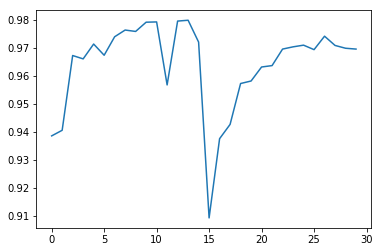

In [23]:
plt.plot(accuracy)

In [20]:
print(loss)

[0.37454348518415254, 0.16619072936557316, 0.12167411898397976, 0.09812249641052566, 0.0829204150696506, 0.07506143394356558, 0.06649163151935984, 0.06243602092167152, 0.05639147490180947, 0.052707788548562805, 0.0492002956410828, 0.04684338900209353, 0.044660410952630326, 0.04254783810516288, 0.04237021210605047, 0.47521380722910556, 0.24057531851652386, 0.1678246728203318, 0.1320295231817691, 0.11073972986408838, 0.09726024542546442, 0.08685881405224179, 0.0794089839575128, 0.07227349779135114, 0.06726165280213116, 0.06208377670602979, 0.05898759173319299, 0.05458086603463304, 0.052406776522111904, 0.051122773362247194]


In [21]:
print(accuracy)

[0.9409, 0.9643, 0.9577, 0.965, 0.9595, 0.9747, 0.9733, 0.9757, 0.9754, 0.9735, 0.9752, 0.9749, 0.9533, 0.9764, 0.9777, 0.9109, 0.9463, 0.9537, 0.9639, 0.9635, 0.9459, 0.9713, 0.974, 0.9634, 0.9755, 0.9743, 0.9713, 0.9746, 0.9737, 0.9759]


In [0]:
from matplotlib.colors import ListedColormap
from matplotlib import colors

def visualize(weights, title, figsize=None):
  plt.figure(figsize=figsize)
  
  cmap = ListedColormap(['k', 'w', 'r'])
  #cax = ax.matshow(x,cmap=cmap)
  data = weights.data.cpu().detach().abs().numpy().flatten()
  half = int(np.sqrt(data.size)) + 1
  data = np.concatenate((data, np.zeros(half * half - data.size)), axis=0)
  data = data.reshape(half, half)
  
  bounds=[0,0.000000000000001,0.5,1.0]
  norm = colors.BoundaryNorm(bounds, cmap.N)
  
  plt.imshow(data, cmap=cmap, norm=norm)
  plt.colorbar()
  plt.title(title)
  plt.axis('off')
  plt.tight_layout()

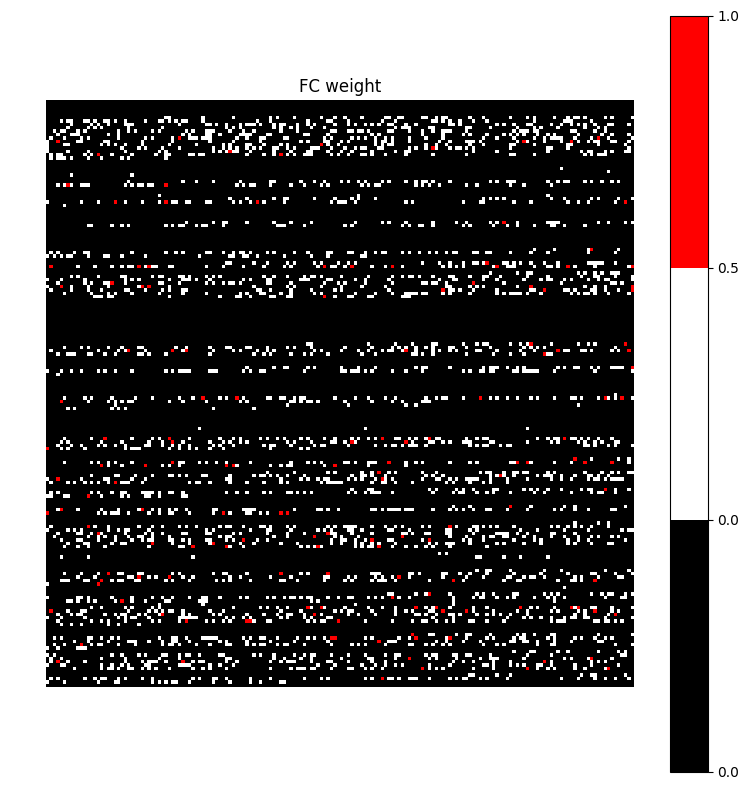

In [186]:
visualize(net.fc2.weight,'FC weight', (8, 8))

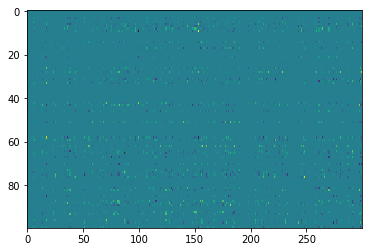

In [47]:
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    
    return hook

weights = net.fc2.weight.data.cpu().numpy()
net.fc2.register_forward_hook(get_activation('fc3'))

x = torch.randn(1, 784)
x = x.cuda()
output = net(x)


plt.imshow(weights, interpolation='nearest', aspect='auto')

In [0]:
-